/Users/lamiya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


End of data loading!


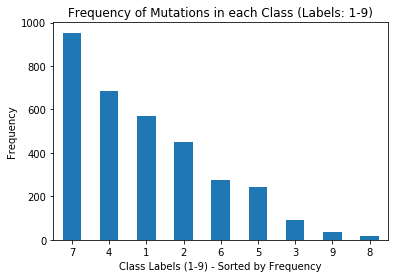

In [4]:
## CS 584 Final Project: Personalized Medicine
## Author: Lamiya Zaveri

#### LOAD IN THE DATA AND OBTAIN PRELIMINARY DESCRIPTIVE STATISTICS ####

# Import statements
%matplotlib inline
import pandas as pd
import numpy as np
import os
import copy
import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from pandas import DataFrame
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_svmlight_file
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# 1. Read in training_variants and training_text files
train_variants = "/Users/lamiya/cs584/data/FinalProject/training_variants.csv"
train_text = "/Users/lamiya/cs584/data/FinalProject/training_text.txt"

train_variants = pd.read_csv(train_variants)
train_text = pd.read_csv(train_text, sep = '\|\|', header = None, skiprows = 1, names = ["ID", "Text"])

# print(train_variants.head())
# print(train_text.head())

# 2. Combine the two files to create a complete set of attributes
# for each mutation, matching each set of attributes on the ID field
train = pd.merge(train_variants, train_text, how = 'left', on = 'ID')
# print(train.head())

# 3. Obtain descriptive statistics for the training data
train.describe(include = 'all')

# 4. Plot the distribution of class identifiers to determine
# whether the data is balanced or unbalanced
freq_plot = train['Class'].value_counts().plot(kind = "bar", rot = 0,\
    title = "Frequency of Mutations in each Class (Labels: 1-9)")
freq_plot.set(xlabel = "Class Labels (1-9) - Sorted by Frequency", \
    ylabel = "Frequency")

print("End of data loading!")

In [5]:
#### FUNCTION FOR GRID SEARCH AND CROSS VALIDATION ####

def cross_validation(X, y, clf, param_grid):
    """ Function to cross-validate results to be used
    for tuning parameters in the model
    
    Prints out accuracy and a confusion matrix
    with 10-fold cross-validation
    
    Args:
        X: Features array
        y: Labels array
        clf: Classifier to use
        param_grid: Grid of parameters to tune
    """
    
    # Split the training data into training and testing sets
    data_train, data_test, labels_train, labels_test = train_test_split(X, y, test_size = 0.20)
    
    # Balance the data
    data_train, labels_train = SMOTE().fit_sample(data_train, labels_train)
    
    # Perform a grid search to tune the parameters for the classifier
    classifier = GridSearchCV(clf, param_grid, cv = 10, scoring = 'f1_weighted')
    classifier.fit(data_train, labels_train)
    
    # Print the grid scores for the training set
    means = classifier.cv_results_['mean_test_score']
    stds = classifier.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, classifier.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    
    # Make a prediction for the test set using the trained model
    labels_pred = classifier.predict(data_test)
    
    # Report the F1 measure and confusion matrix
    print("F1 Score: ", f1_score(labels_test, labels_pred, average = 'weighted'))
    skplt.metrics.plot_confusion_matrix(labels_test, labels_pred)
    
    print("End of cross-validation!")

In [6]:
#### FEATURE SELECTION AND DIMENSIONALITY REDUCTION ####
#### LATENT SEMANTIC ANALYSIS (LSA) ####

# Import statements
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
nltk.download('punkt')

from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD

# 1. Transform the text from the second file into a BOW representation
# using CountVectorizer to generate a frequency matrix for single words
vectorizer = CountVectorizer(analyzer = "word", tokenizer = nltk.word_tokenize, stop_words = 'english')
X = vectorizer.fit_transform(train['Text'].values.astype('U'))
print("Number of unique words: ", len(vectorizer.get_feature_names()))

# 2. Use the TfidfTransformer to normalize the frequency matrix
transformer = TfidfTransformer()
X = transformer.fit_transform(X)

# 3. Use SVD to reduce the dimensionality of the text data
svd = TruncatedSVD(n_components = 100)
X = svd.fit_transform(X)
print("Shape of array after SVD: ", np.shape(X))

print("End of feature selection & dimensionality reduction!")

[nltk_data] Downloading package punkt to /Users/lamiya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Number of unique words:  281467
Shape of array after SVD:  (3321, 50)
End of feature selection & dimensionality reduction!


In [7]:
#### ADD THE INFORMATION FROM THE FIRST FILE ####

# Import statements
from sklearn.preprocessing import LabelEncoder

# 1. Use a hot encoder to encode the gene field 
gene_le = LabelEncoder()
gene_encoded = gene_le.fit_transform(train['Gene'].values.ravel()).reshape(-1, 1)
gene_encoded = gene_encoded / np.max(gene_encoded)

# 2. Use a hot encoder to encode the variation field
variation_le = LabelEncoder()
variation_encoded = variation_le.fit_transform(train['Variation'].values.ravel()).reshape(-1, 1)
variation_encoded = variation_encoded / np.max(variation_encoded)

# 3. Combine the information from the first and second files
X = np.hstack((gene_encoded, variation_encoded, X))
print(X.shape)

print("End of combining fields from the first & second files!")

(3321, 52)
End of combining fields from the first & second files!


In [8]:
# #### EVALUATE CLASSIFIERS USING UNBALANCED DATA ####

# ## Classification models:
# # 1. K nearest neighbors
# # 2. SVC
# # 3. Decision Tree Classifier

# ## Cross Validation/F1 Scoring Metric:
# # cross_validation(X, y, clf, param_grid)
# # F = 2a / (2a + b + c)

# # Import statements
# from sklearn.svm import SVC
# from sklearn.naive_bayes import ComplementNB

# # 1. K nearest neighbors
# data = copy.deepcopy(X)
# param_grid = [{'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}]
# cross_validation(data, train['Class'].values.ravel(), KNeighborsClassifier(), param_grid)

# # 2. SVC
# data = copy.deepcopy(X)
# param_grid = [{'C': [0.1, 1, 10, 100], 'gamma': [1, 10, 100]}]
# cross_validation(data, train['Class'].values.ravel(), SVC(), param_grid)

# # 3. Decision tree classifer
# data = copy.deepcopy(X)
# param_grid = [{'max_depth': [20, 40, 80, 160], 'min_samples_split': [8, 16, 32, 64, 128]}]
# cross_validation(data, train['Class'].values, DecisionTreeClassifier(), param_grid)

# print("End of evaluating the unbalanced data!")

In [11]:
# #### BALANCE THE DATA ####

# # Import statements
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

# param_grid = [{'C': [10], 'gamma': [1]}]

# # 1. Undersampling
# # The following lines are copied into the cross_validation method:
# # rus = RandomUnderSampler(random_state = 0)
# # data_train, labels_train = rus.fit_sample(data_train, labels_train)

# # 2. Oversampling
# # The following lines are copied into the cross_validation method:
# # ros = RandomOverSampler(random_state = 0)
# # data_train, labels_train = ros.fit_sample(data_train, labels_train)

# # 3. SMOTE
# # The following line is copied into the cross_validation method:
# # data_train, labels_train = SMOTE().fit_sample(data_train, labels_train)

# data = copy.deepcopy(X)
# cross_validation(data, train['Class'].values.ravel(), SVC(), param_grid)

# print("End of balancing the data!")

0.809 (+/-0.054) for {'n_neighbors': 3}
0.777 (+/-0.048) for {'n_neighbors': 5}
0.759 (+/-0.046) for {'n_neighbors': 7}
0.737 (+/-0.056) for {'n_neighbors': 9}
0.718 (+/-0.051) for {'n_neighbors': 11}
0.701 (+/-0.050) for {'n_neighbors': 13}
0.687 (+/-0.040) for {'n_neighbors': 15}
0.674 (+/-0.039) for {'n_neighbors': 17}
0.670 (+/-0.037) for {'n_neighbors': 19}
0.660 (+/-0.044) for {'n_neighbors': 21}
F1 Score:  0.5193575943832597
End of cross-validation!


/Users/lamiya/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.540 (+/-0.037) for {'C': 0.1, 'gamma': 1}
0.668 (+/-0.050) for {'C': 0.1, 'gamma': 10}
0.521 (+/-0.055) for {'C': 0.1, 'gamma': 100}
0.658 (+/-0.043) for {'C': 1, 'gamma': 1}
0.815 (+/-0.054) for {'C': 1, 'gamma': 10}
0.842 (+/-0.094) for {'C': 1, 'gamma': 100}
0.770 (+/-0.045) for {'C': 10, 'gamma': 1}
0.871 (+/-0.069) for {'C': 10, 'gamma': 10}
0.846 (+/-0.093) for {'C': 10, 'gamma': 100}
0.845 (+/-0.057) for {'C': 100, 'gamma': 1}
0.870 (+/-0.077) for {'C': 100, 'gamma': 10}
0.845 (+/-0.091) for {'C': 100, 'gamma': 100}
F1 Score:  0.5843440112742458
End of cross-validation!
0.752 (+/-0.055) for {'max_depth': 20, 'min_samples_split': 8}
0.734 (+/-0.046) for {'max_depth': 20, 'min_samples_split': 16}
0.705 (+/-0.044) for {'max_depth': 20, 'min_samples_split': 32}
0.670 (+/-0.045) for {'max_depth': 20, 'min_samples_split': 64}
0.610 (+/-0.044) for {'max_depth': 20, 'min_samples_split': 128}
0.750 (+/-0.059) for {'max_depth': 40, 'min_samples_split': 8}
0.732 (+/-0.052) for {'max_dept

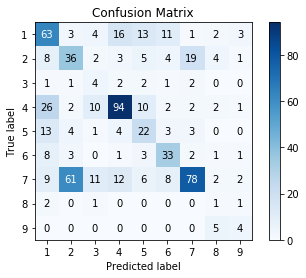

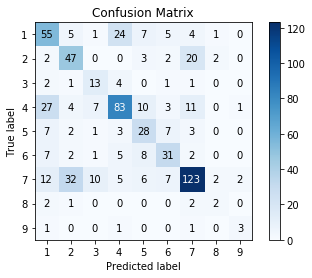

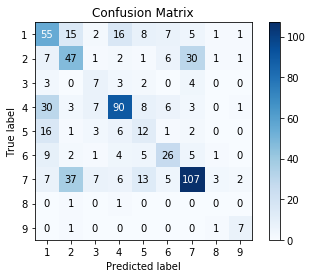

In [12]:
#### EVALUATE CLASSIFIERS USING BALANCED DATA ####

## Classification models:
# 1. K nearest neighbors
# 2. SVC
# 3. Decision Tree Classifier

## Cross Validation/F1 Scoring Metric:
# cross_validation(X, y, clf, param_grid)
# F = 2a / (2a + b + c)

# # Balance the data using the SMOTE technique
# The following line is copied into the cross_validation method:
# data_train, labels_train = SMOTE().fit_sample(X, train['Class'].values.ravel())

# 1. K nearest neighbors
data = copy.deepcopy(X)
param_grid = [{'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}]
cross_validation(data, train['Class'].values.ravel(), KNeighborsClassifier(), param_grid)

# 2. SVC
data = copy.deepcopy(X)
param_grid = [{'C': [0.1, 1, 10, 100], 'gamma': [1, 10, 100]}]
cross_validation(data, train['Class'].values.ravel(), SVC(), param_grid)

# 3. Decision tree classifer
data = copy.deepcopy(X)
param_grid = [{'max_depth': [20, 40, 80, 160], 'min_samples_split': [8, 16, 32, 64, 128]}]
cross_validation(data, train['Class'].values.ravel(), DecisionTreeClassifier(), param_grid)

print("End of evaluating the balanced data!")